In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/Shared drives/Cse 544' 

/content/gdrive/Shared drives/Cse 544


In [4]:
!ls 

CSE544.ipynb  stocks.csv  us-states.csv


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import math
from pprint import pprint
from scipy.stats import geom, poisson, binom
from scipy.stats import chi2_contingency

states = ['California', 'New York', 'Washington']

In [0]:
def outlier(data, length, alpha):
    quartile1 = data[length]
    quartile2 = data[length*2]
    quartile3 = data[length*3]
    interquartile = quartile3 - quartile1
    lower_limit = quartile1 - (alpha * interquartile)
    upper_limit = quartile3 + (alpha * interquartile)
    print("Quartile1: " + str(quartile1))
    print("Quartile2: " + str(quartile2))
    print("Quartile3: " + str(quartile3))
    print("Interquartile: " + str(interquartile))
    print("Lower limit: " + str(lower_limit))
    print("Upper limit: " + str(upper_limit))
    flag = 0
    for i,num in enumerate(data):
        if num < lower_limit or num > upper_limit: 
            flag = +1
            print("Excluded value: " + str(num))
    return flag, lower_limit, upper_limit

In [0]:
def retrieve_data(covid_fpath, stock_fpath):
    # Data cleaning and outlier for Covid dataset
    data_states = pd.read_csv(covid_fpath)
    states = ['California', 'New York', 'Washington']
    data_states['date'] = pd.to_datetime(data_states["date"])

    # Generating all dates to find missing values
    all_dates = set()
    start_date = datetime.strptime('2020-01-01', '%Y-%m-%d')
    end_date = data_states.date.max()
    while start_date<end_date:
        all_dates.add(start_date)
        start_date = start_date + timedelta(1)

    state_df = pd.DataFrame(columns=['date', 'state', 'cases', 'deaths'])

    for st in states:
        st_df = data_states[data_states.state == st][['date', 'state', 'cases', 'deaths']].sort_values(by='date', axis=0, ascending=True)
        st_missing_dates = all_dates - set(st_df.date.tolist())
        new_df = []
        # Replace missing values with 0 (cases, deaths)
        for dt in st_missing_dates:
            new_df.append([dt, st, 0, 0])
        new_df = pd.DataFrame(new_df, columns=['date', 'state', 'cases', 'deaths'])

        # Converting cumulative case counts to new cases
        st_new_cases = np.array([0]*st_df.shape[0])
        old_case_count = 0 
        for i in range(st_df.shape[0]):
            st_new_cases[i] = st_df.iloc[i].cases - old_case_count
            old_case_count = st_df.iloc[i].cases
        st_df['cases'] = st_new_cases

        # Converting cumulative death counts to new deaths
        st_new_deaths = np.array([0]*st_df.shape[0])
        old_death_count = 0
        for i in range(st_df.shape[0]):
            st_new_deaths[i] = st_df.iloc[i].deaths - old_death_count
            old_death_count = st_df.iloc[i].deaths
        st_df['deaths'] = st_new_deaths
        state_df = state_df.append(new_df)
        state_df = state_df.append(st_df)

    # contains data of 3 states (at date, state level)
    state_df.sort_values(by=['date', 'state'], inplace=True)
    state_df.reset_index(drop=True, inplace=True)

    # contains daily data of 3 states (at date level)
    current_df = state_df[['date', 'cases', 'deaths']]
    current_df = current_df.groupby("date").sum()
    current_df['date'] = current_df.index
    current_df.reset_index(drop=True, inplace=True)
    current_df = current_df[['date', 'cases', 'deaths']]
    
    # alpha for outlier detection
    outlier_alpha = 1.4
    print("==========Cases Outlier===========")
    domain = current_df['cases'].sort_values().values.tolist()
    case_flag, case_lower, case_upper = outlier(domain, len(domain)//4, outlier_alpha)
    print("Outliers in cases: ", case_flag)
    
    print("==========Deaths Outlier===========")
    domain = current_df['deaths'].sort_values().values.tolist()
    print(current_df[current_df['deaths'] == 892])
    death_flag, death_lower, death_upper = outlier(domain, len(domain)//4, outlier_alpha)
    if death_flag == 0: print("No Outlier detected")
    print("Outliers in deaths: ", death_flag)
    
    # Removing outliers from covid dataset
    current_df = current_df.loc[(current_df['cases']>=case_lower) & (current_df['cases']<=case_upper) \
                  & (current_df['deaths']>=death_lower) & (current_df['deaths']<=death_upper)].reset_index(drop=True)
    
    # Stock dataset cleaning containing stock prices after 2020-01-01
    stock_df = pd.read_csv(stock_fpath, names=['date', 'Open', 'High', 'Low', 'Close', 'Change'], header=0)
    stock_df = stock_df[stock_df.Open.isna()==False][['date', 'Close', 'Change']]
    stock_df['date'] = pd.to_datetime(stock_df["date"])
    end_date = current_df.date.max()
    stock_df = stock_df.loc[(stock_df.date>='2020-01-01') & (stock_df.date<=end_date)].sort_values(by='date').reset_index(drop=True)
    
    print("==========Stock Outlier===========")
    domain = stock_df['Close'].sort_values().values.tolist()
    stock_flag, stock_lower, stock_upper = outlier(domain, len(domain)//4, outlier_alpha)
    print("Outliers in stock: ", stock_flag)
    
    # Removing outliers from stock dataset
    stock_df = stock_df.loc[(stock_df['Close']>=stock_lower) & (stock_df['Close']<=stock_upper)].reset_index(drop=True)

    # Combined dataset containing both stock and covid in single dataframe (inner join)
    covid_stock_df = current_df.join(stock_df.set_index('date'), on='date', how='inner', lsuffix='covid_', rsuffix='stock_').reset_index(drop=True)
    
    # complete stock dataset
    all_stock_df = pd.read_csv(stock_fpath, names=['date', 'Open', 'High', 'Low', 'Close', 'Change'], header=0)
    all_stock_df = all_stock_df[all_stock_df.Open.isna()==False][['date', 'Close', 'Change']]
    all_stock_df['date'] = pd.to_datetime(all_stock_df["date"])
    all_stock_df = all_stock_df.reset_index(drop=True)
    current_df = current_df[current_df['date'] <= "2020-04-30"]
    stock_df = stock_df[stock_df['date'] <= "2020-04-30"]
    covid_stock_df = covid_stock_df[covid_stock_df['date'] <= "2020-04-30"]
    state_df = state_df[state_df['date'] <= "2020-04-30"]
    all_stock_df = all_stock_df[all_stock_df['date'] <= "2020-04-30"]
    return current_df, stock_df, covid_stock_df, state_df, all_stock_df


# Data retrieval and cleaning



In [9]:
covid_fpath = 'us-states.csv'
stock_fpath = 'stocks.csv'
current_df, stock_df, covid_stock_df, state_df, all_stock_df = retrieve_data(covid_fpath, stock_fpath)
stock_df.shape, covid_stock_df.shape, all_stock_df.shape

==========Cases Outlier===========
Quartile1: 0
Quartile2: 13
Quartile3: 6772
Interquartile: 6772
Lower limit: -9480.8
Upper limit: 16252.8
Outliers in cases:  0
==========Deaths Outlier===========
         date  cases  deaths
97 2020-04-07  10946     892
Quartile1: 0
Quartile2: 1
Quartile3: 368
Interquartile: 368
Lower limit: -515.1999999999999
Upper limit: 883.1999999999999
Excluded value: 892
Outliers in deaths:  1
==========Stock Outlier===========
Quartile1: 1479.68
Quartile2: 1608.6
Quartile3: 1701.97
Interquartile: 222.28999999999996
Lower limit: 1168.4740000000002
Upper limit: 2013.176
Outliers in stock:  0


((83, 3), (82, 5), (633, 3))

# Data Visualization

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
curr_filter = (covid_stock_df['date']>="2020-03-01") & (covid_stock_df['date']<"2020-05-01")
df = covid_stock_df.loc[curr_filter]
curr_filter = (state_df['date']>="2020-03-01") & (state_df['date']<"2020-05-01")
states = state_df.loc[curr_filter]
df["Market Volatility"] = (round(df['Change']/df['Close'] * 100,2))
df.drop(['Change'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1. We filter out the data after March till April End as there were hardly any cases in February for Washnigton and California and there were no cases in New york.

Text(0.5, 1.0, 'No. of cases')

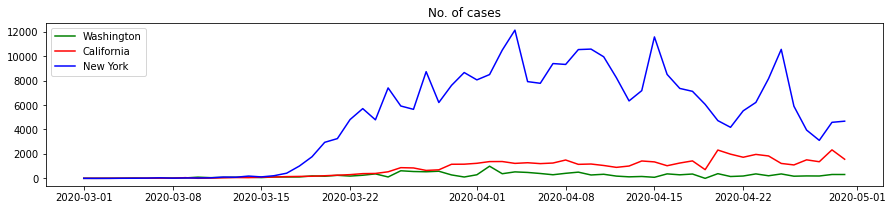

In [55]:
plt.figure(figsize=(15,3))
for state,color in [('Washington', 'Green'), ('California', 'Red'), ('New York', 'Blue')]:
    x = states.loc[states['state']==state]['date']
    y = states.loc[states['state']==state]['cases']
    plt.plot(x, y, c=color, label=state)
plt.legend()
plt.title("No. of cases")

The plot above shows the timeline for the number of cases for each state. We can observe the high number of cases for New York as compared to California and Washington.

Text(0.5, 1.0, 'No. of deaths')

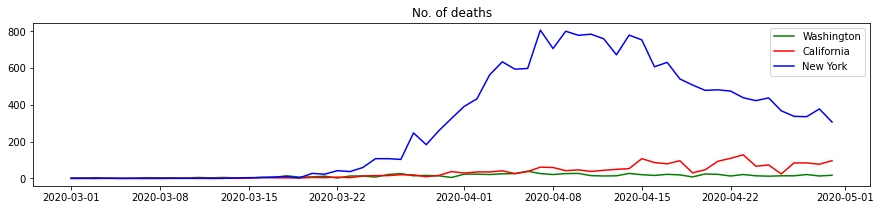

In [56]:
plt.figure(figsize=(15,3))
for state,color in [('Washington', 'Green'), ('California', 'Red'), ('New York', 'Blue')]:
    x = states.loc[states['state']==state]['date']
    y = states.loc[states['state']==state]['deaths']
    plt.plot(x, y, c=color, label=state)
plt.legend()
# plt.yscale('log')
plt.title("No. of deaths")

The plot above shows the timeline for the number of deaths for each state. We can observe the high number of deaths for New York as compared to California and Washington.

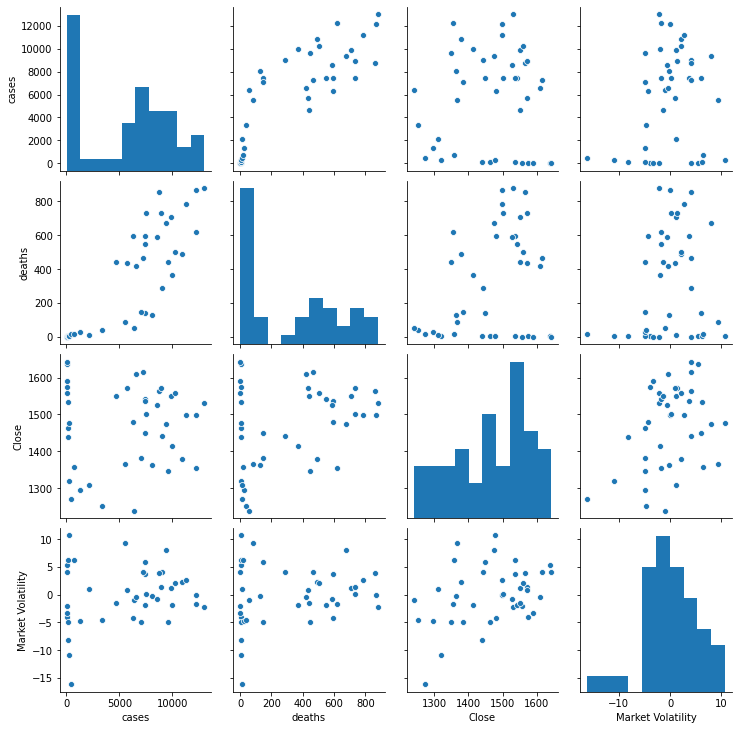

In [58]:
sns.pairplot(df)

**Scatter Plot Matrix**

This kind of matrix is useful to bivariate distributions and univariate(histogram) distribution of a variable easily.
1.   From the plot between #cases and #deaths, we see that as number of cases increases, the death count is high as well.
1.   From the plot between #cases vs Close Price and #deaths vs Close Price, we can observe that during the initial phase, the stock prices were low, but there seems to be no correlation between #cases and #deaths with the Closing Price.
2.   From the above, market volatility seems to be more during Covid.



# Required Inferences 1 (AR and EWMA)

**Calculation of $\hat{\beta}$**

This is the code segment for calculating the estimates of the coefficients.i.e. Beta OLS matrix. For AR(3), the X dataset is constructed by taking into account the previous 3 days of observed cases and deaths. Similarly for AR(5), X dataset consiers the previous 5 days of information. The start date of   consideration is April 1, 2020. Thus the first new cases and deaths number observed placed in the Y_obs_cases and Y_obs_deaths is taken for 3 days later i.e. April 4, 2020. After the prearation of the X and Y matrices, the Beta OLS is calculated with the formula: 
$\hat{\beta} = (X^{T}X)^{-1} X^{T} Y$





In [0]:
def beta_hat_calc(current_df, iter,n):
  start_date = datetime.strptime('2020-04-01', '%Y-%m-%d')
  start_index = current_df.index[current_df['date'] == start_date][0]
  X_cases = []
  X_deaths = []
  Y_obs_cases=[]
  Y_obs_deaths = []
  col_cases = current_df['cases']
  col_deaths = current_df['deaths']
  if n == 3:
    for i in range(start_index , start_index + iter):
      Y_obs_cases.append(col_cases[i+3])
      Y_obs_deaths.append(col_deaths[i+3])
      X_cases.append([1,col_cases[i+2],col_cases[i+1], col_cases[i]])
      X_deaths.append([1,col_deaths[i+2],col_deaths[i+1], col_deaths[i]])
  if n == 5:
    for i in range(start_index , start_index + iter):
      Y_obs_cases.append(col_cases[i+5])
      Y_obs_deaths.append(col_deaths[i+5])
      X_cases.append([1,col_cases[i+4],col_cases[i+3], col_cases[i+2], col_cases[i+1], col_cases[i]])
      X_deaths.append([1,col_deaths[i+4],col_deaths[i+3], col_deaths[i+2], col_deaths[i+1], col_deaths[i]])
  Y_obs_cases = np.array(Y_obs_cases)
  Y_obs_deaths = np.array(Y_obs_deaths)
  X_cases = np.array(X_cases)
  X_deaths = np.array(X_deaths)
  beta_hat_cases = np.dot(np.dot(np.linalg.pinv(np.dot(X_cases.transpose(),X_cases)),X_cases.transpose()),Y_obs_cases)
  beta_hat_deaths = np.dot(np.dot(np.linalg.pinv(np.dot(X_deaths.transpose(),X_deaths)),X_deaths.transpose()),Y_obs_deaths)
  return (beta_hat_cases, beta_hat_deaths, Y_obs_cases, Y_obs_deaths)

**MAPE**

The function takes in in the predicted values and their respective error predictions and calculates the mean average percentage error using:
MAPE% =  $(\sum_{i=0}^{n} |E_i|/ Y_i)/ n $.This MAPE% is then returned.

In [0]:
def mape(Y_obs,error_hat):
  n=len(error_hat)
  sum=0
  for i in range(n):
    sum+= abs(error_hat[i])/Y_obs[i]
  return (sum*100/n)

**MSE**

This function takes in the predicted errror values for the 7 days and calculates the mean squared error by applying the formula: 
$MSE = \sum_{i=1}^{n} (E_i)^2$. This error is then returned for further interpretation.

In [0]:
def mse(error_hat):
  n = len(error_hat)
  sum=0
  for i in range(n):
    sum+= error_hat[i] ** 2
  return (sum/n)

**AR(3)**

The function will make predictions for the i*th* day of the week by taking into consideration all the data from the previous days uptil April 1, 2020. Thus, we will have 17 data points as one is outlier for training for the first day of the fourth week. It calls the `beta_hat_calc()` and uses these values as the coefficients of the previously observed cases and deaths. Thus, $\hat{Y} = \hat{\beta}Y_{obs}$, where the $\hat{\beta}$ has 4 values and $Y_{obs}$ has the values of the three previous days.

In [0]:
def ar_3(current_df):
  error_hat_cases =[]
  error_hat_deaths = []
  for day in range(7):
    beta_hat_cases , beta_hat_deaths, Y_obs_cases, Y_obs_deaths = beta_hat_calc(current_df,17+day,3)
    Y_pred_cases = beta_hat_cases[0] + (beta_hat_cases[1] * Y_obs_cases[-1]) + (beta_hat_cases[2] * Y_obs_cases[-2]) + (beta_hat_cases[3] * Y_obs_cases[-3])
    Y_pred_deaths = beta_hat_deaths[0] + (beta_hat_deaths[1] * Y_obs_deaths[-1]) + (beta_hat_deaths[2] * Y_obs_deaths[-2]) + (beta_hat_deaths[3] * Y_obs_deaths[-3])
    error_hat_cases.append(Y_obs_cases[-day] - Y_pred_cases)
    error_hat_deaths.append(Y_obs_deaths[-day] - Y_pred_deaths)
  print("MAPE for no. of new cases using AR(3) =" + str(mape(Y_obs_cases[-7:] , error_hat_cases)) + "%")
  print("MSE for no. of new cases using AR(3) = " + str(mse(error_hat_cases)))
  print("MAPE for no. of new deaths using AR(3) =" + str(mape(Y_obs_deaths[-7:] , error_hat_deaths)) + "%")
  print("MSE for no. of new deaths using AR(3) = " + str(mse(error_hat_deaths)))

**AR(5)**

The function will make predictions for the i*th* day of the week by taking into consideration all the data from the previous days uptil April 1, 2020. Thus, we will have 21 days out of which one is an outlier and thus, 15 data points for training for the first day of the fourth week. It calls the `beta_hat_calc()` and uses these values as the coefficients of the previously observed cases and deaths. Thus, $\hat{Y} = \hat{\beta}Y_{obs}$, where the $\hat{\beta}$ has 6 values and $Y_{obs}$ has the values of the five previous days.

In [0]:
def ar_5(current_df):
  error_hat_cases =[]
  error_hat_deaths = []
  for day in range(7):
    beta_hat_cases , beta_hat_deaths, Y_obs_cases, Y_obs_deaths = beta_hat_calc(current_df,15+day,5)
    Y_pred_cases = beta_hat_cases[0] + (beta_hat_cases[1] * Y_obs_cases[-1]) + (beta_hat_cases[2] * Y_obs_cases[-2]) + (beta_hat_cases[3] * Y_obs_cases[-3]) + (beta_hat_cases[4] * Y_obs_cases[-4]) + (beta_hat_cases[5] * Y_obs_cases[-5])
    Y_pred_deaths = beta_hat_deaths[0] + (beta_hat_deaths[1] * Y_obs_deaths[-1]) + (beta_hat_deaths[2] * Y_obs_deaths[-2]) + (beta_hat_deaths[3] * Y_obs_deaths[-3]) + (beta_hat_deaths[4] * Y_obs_deaths[-4]) + (beta_hat_deaths[5] * Y_obs_deaths[-5])
    error_hat_cases.append(Y_obs_cases[-day] - Y_pred_cases)
    error_hat_deaths.append(Y_obs_deaths[-day] - Y_pred_deaths)
  print("MAPE for no. of new cases using AR(5) =" + str(mape(Y_obs_cases[-7:] , error_hat_cases)) + "%")
  print("MSE for no. of new cases using AR(5) = " + str(mse(error_hat_cases)))
  print("MAPE for no. of new deaths using AR(5) =" + str(mape(Y_obs_deaths[-7:] , error_hat_deaths)) + "%")
  print("MSE for no. of new deaths using AR(5) = " + str(mse(error_hat_deaths)))

**EWMA**

The Exponentially Weighted Moving Average is a statistic for monitoring the process that averages the data in a way that gives certain weights to data as they are further removed in time. In this function, parameters accepted is the complete data frame and $\alpha$. The calculation for this is done with the formula: $\hat{y}_{t+1|t} = \alpha y_{t} + (1-\alpha)\hat{y}_{t|t-1}$
When the $\hat{Y}_{4th\_week\_1st\_day}$ data is calculated, the estimated value of $3^{rd}$ week last day is taken aqs the observed value for this day. The MAPE and MSE is then calculated for the values of all 7 days each for no. of cases and deaths. 

In [0]:
def ewma(current_df,alpha):
  #declaring the start date which will be the seed value for the ewma 7 day estimation
  start_date = datetime.strptime('2020-04-22', '%Y-%m-%d')
  start_i = current_df.index[current_df['date'] == start_date][0]
  col_cases = current_df['cases'] #the coloumn of new cases in the current_df
  col_deaths = current_df['deaths'] #the coloumn of new deaths in the current_df
  #Initializing the Y lists with the seed value
  Y_obs_cases = [col_cases[start_i]]
  Y_obs_deaths = [col_deaths[start_i]]
  Y_pred_cases = [col_cases[start_i]]
  Y_pred_deaths = [col_deaths[start_i]]
  error_hat_cases = []
  error_hat_deaths = []
  # p_alpha = 1- alpha
  for i in range(7):
    Y_pred_cases.append( (alpha*Y_obs_cases[-1]) + ((1-alpha)*Y_pred_cases[-1]))
    Y_pred_deaths.append( (alpha*Y_obs_deaths[-1]) + ((1-alpha)*Y_pred_deaths[-1]))
    Y_obs_cases.append(col_cases[start_i +i+1])
    Y_obs_deaths.append(col_deaths[start_i +i+1])
    error_hat_cases.append(Y_obs_cases[i+1] - Y_pred_cases[i+1])
    error_hat_deaths.append(Y_obs_deaths[i+1] - Y_pred_deaths[i+1])
  # print(alpha)
  print("MAPE for EWMA for new cases with alpha=" + str(alpha)+ " is " + str(mape(Y_obs_cases[1:] , error_hat_cases)) + "%")
  print("MSE for EWMA for new cases with alpha=" + str(alpha)+ " is " + str(mse(error_hat_cases)))
  print("MAPE for EWMA for new deaths with alpha=" + str(alpha)+ " is " + str(mape(Y_obs_deaths[1:] , error_hat_deaths)) + "%")
  print("MSE for EWMA for new deaths with alpha=" + str(alpha)+ " is " + str(mse(error_hat_deaths)))

In [115]:
def req_inf_1():
  fpath = 'us-states.csv'
  ar_3(current_df)
  ar_5(current_df)
  ewma(current_df,0.5)
  ewma(current_df,0.8)
req_inf_1()

MAPE for no. of new cases using AR(3) =29.01762349191649%
MSE for no. of new cases using AR(3) = 9881121.683757465
MAPE for no. of new deaths using AR(3) =16.645945791301163%
MSE for no. of new deaths using AR(3) = 9508.553471027186
MAPE for no. of new cases using AR(5) =19.637671859666206%
MSE for no. of new cases using AR(5) = 5219420.50237885
MAPE for no. of new deaths using AR(5) =19.053503497288908%
MSE for no. of new deaths using AR(5) = 11929.959874241855
MAPE for EWMA for new cases with alpha=0.5 is 33.98909263800348%
MSE for EWMA for new cases with alpha=0.5 is 6576465.252685547
MAPE for EWMA for new deaths with alpha=0.5 is 10.183892624800373%
MSE for EWMA for new deaths with alpha=0.5 is 3890.1578194754466
MAPE for EWMA for new cases with alpha=0.8 is 31.23451320883317%
MSE for EWMA for new cases with alpha=0.8 is 6210936.420294457
MAPE for EWMA for new deaths with alpha=0.8 is 8.160593689768021%
MSE for EWMA for new deaths with alpha=0.8 is 3153.171963761223


**Inference**

As we can observe the MAPE and MSE reported are quite high. Reason for this is that the number of cases and deaths were growing somewhat exponentially for the dates under consideration.Since, AR(3) and AR(5) are regression models much suited for linear correlations, the **exponential curve** yield high error.
EWMA  improves on simple variance by assigning weights to the periodic returns. By doing this, we can give greater weight to more recent returns. Hence error in EWMA smoothening is not very efficient due to the **exponential growth**. What happens here is that the weighted average is taken from previous true and estimated value i.e Error is being minimized given the previous data growth, however the new data point exceeds that error value and thus the smoothening doesn't happen easily. 
We can also observe that the EWMA with $\alpha = 0.8 $ has less error as the weigthage for the true value is higher and the estimate for every new day is predicted closer to the previous day's actual value.

# Required Inferences 2 (Wald's, Z, T tests)

Here onwards, when we mention null hypothesis, we  mean that last week's mean = second last week's mean. When we talk about mean, we are talking about number of new deaths and new cases per day. <br>
In all 1 sample and 2 sample, previous week's mean would refer to different things in accordance with the questions. Basically in 1 sample tests, we take last week's mean as MLE of last week's mean. In 2 sample test, we take both the distribution's together and work on them as required in respective tests.

In [19]:
## DATA PREPARATION

curr_wk_end_dt = current_df.date.max()
curr_wk_st_dt = current_df.date.max()-timedelta(6)

prev_wk_st_dt = current_df.date.max() - timedelta(13)
prev_wk_end_dt = current_df.date.max() - timedelta(7)

# Last available week of data 
curr_filter = (current_df['date']>=curr_wk_st_dt) & (current_df['date']<=curr_wk_end_dt)
curr_wk_df = current_df.loc[curr_filter]

# Second to last available week of data
prev_filter = (current_df['date']>=prev_wk_st_dt) & (current_df['date']<=prev_wk_end_dt)
prev_wk_df = current_df.loc[prev_filter]

# alpha values
z_half_alpha = 1.96
z_alpha = 1.64
t_12_half_alpha = 2.1788
t_6_half_alpha = 2.4469

print(curr_wk_df)
print(prev_wk_df)

          date  cases  deaths
113 2020-04-24  10209     502
114 2020-04-25  12139     522
115 2020-04-26   7182     405
116 2020-04-27   5669     435
117 2020-04-28   4667     440
118 2020-04-29   7238     467
119 2020-04-30   6563     419
          date  cases  deaths
106 2020-04-17   8907     731
107 2020-04-18   8909     655
108 2020-04-19   6772     545
109 2020-04-20   7430     549
110 2020-04-21   6313     596
111 2020-04-22   7449     596
112 2020-04-23   8542     587


In [14]:
# Wald's 1 population test 
def get_W_one_pop(prev_wk, curr_wk):
    theta_not = prev_wk.sum()/prev_wk.shape[0]
    theta_hat = curr_wk.sum()/curr_wk.shape[0]
    se_theta_hat = (np.sum(np.square(np.array(curr_wk) - theta_hat))/(curr_wk.shape[0]**2))**0.5
    w_stat = abs((theta_hat - theta_not)/se_theta_hat)
    ret_str = "H_0 rejected" if w_stat > z_half_alpha else "Failed to reject H_0"
    return w_stat, ret_str

print("W-statistic (mean of last 2 week's death count - 1 pop): "+ str(get_W_one_pop(prev_wk_df.deaths, curr_wk_df.deaths)))
print("W-statistic (mean of last 2 week's cases count - 1 pop): "+ str(get_W_one_pop(prev_wk_df.cases, curr_wk_df.cases)))


W-statistic (mean of last 2 week's death count - 1 pop): (10.074407882043083, 'H_0 rejected')
W-statistic (mean of last 2 week's cases count - 1 pop): (0.10218093725293219, 'Failed to reject H_0')


We can see that for number of cases in Wald's test, the hypothesis can't be rejected. In cases of deaths, we see that hypothesis is rejected. <br>
Wald's test requirements aren't met i.e. we need AN estimator of mu. As our data sample is very small, we can't call it AN estimator of mu.

In [0]:
#Wald's 2 population test comparing means of last 2 weeks against each other
def get_W_two_pop(prev_wk, curr_wk):
    prev_wk_mean_mle = prev_wk.sum()/prev_wk.shape[0]
    curr_wk_mean_mle = curr_wk.sum()/curr_wk.shape[0]
    delta_hat = prev_wk_mean_mle - curr_wk_mean_mle
    # numerator of 2 population W statistic
    se_prev_component = np.sum(np.square(np.array(prev_wk) - prev_wk_mean_mle))/(prev_wk.shape[0]**2)
    se_curr_component = np.sum(np.square(np.array(curr_wk) - curr_wk_mean_mle))/(curr_wk.shape[0]**2)
    # denominator of 2 population W statistic
    se_hat = (se_prev_component + se_curr_component) ** 0.5
    w_statistic = abs(delta_hat/se_hat)
    ret_str = "H_0 rejected" if w_statistic > z_half_alpha else "Failed to reject H_0"
    return w_statistic, ret_str

print("W-statistic (mean of last 2 week's death count - 2 population): "+ str(get_W_two_pop(prev_wk_df.deaths, curr_wk_df.deaths)))
print("W-statistic (mean of last 2 week's cases count - 2 population): "+ str(get_W_two_pop(prev_wk_df.cases, curr_wk_df.cases)))


W-statistic (mean of last 2 week's death count - 2 population): (5.574430702456671, 'H_0 rejected')
W-statistic (mean of last 2 week's cases count - 2 population): (0.09492400644720578, 'Failed to reject H_0')


We can see that for number of cases in Wald's 2 population test, the hypothesis can't be rejected. For number of deaths, we see that hypothesis is rejected. <br>
Wald's test requirements aren't met i.e. we need AN estimator of mu. As both of our data samples (last and second last week numbers) are very small, we can't call MLE estimator as AN estimator of mu.

In [0]:
# Z test 1 population
def get_zstat(prev_wk, curr_wk):
    theta_not = prev_wk.sum()/prev_wk.shape[0]
    sample_mean = curr_wk.sum()/curr_wk.shape[0]
    sample_sd = (np.sum(np.square(np.array(curr_wk) - sample_mean))/curr_wk.shape[0])**0.5
    z_stat = abs((sample_mean - theta_not)/(sample_sd/(curr_wk.shape[0]**0.5)))
    ret_str = "H_0 rejected" if z_stat > z_half_alpha else "Failed to reject H_0"
    return z_stat, ret_str

print("Z-statistic (mean of last 2 week's death count - 1 pop): "+ str(get_zstat(prev_wk_df.deaths, curr_wk_df.deaths)))
print("Z-statistic (mean of last 2 week's cases count - 1 pop): "+ str(get_zstat(prev_wk_df.cases, curr_wk_df.cases)))


Z-statistic (mean of last 2 week's death count - 1 pop): (10.074407882043083, 'H_0 rejected')
Z-statistic (mean of last 2 week's cases count - 1 pop): (0.1021809372529322, 'Failed to reject H_0')


For Z test, we see that hypothesis is rejected for number of death counts and we can't reject the hypothesis for number of cases. <br>
We can't use z-test because of following reasons: <br>
1.   True standard deviation is not known
2.   n is small and we can't assume that data is normally distributed.



In [0]:
def get_tstat_one_pop(prev_wk, curr_wk):
    mu_not = prev_wk.sum()/prev_wk.shape[0]
    sample_mean = curr_wk.sum()/curr_wk.shape[0]
    sample_sd = ((np.sum(np.square(np.array(curr_wk) - sample_mean))/curr_wk.shape[0]))**0.5
    t_stat = abs((sample_mean - mu_not)/(sample_sd/(curr_wk.shape[0]**0.5)))
    ret_str = "H_0 rejected" if t_stat > t_6_half_alpha else "Failed to reject H_0"
    return t_stat, ret_str

print("T-statistic (mean of last 2 week's death count - 1 pop): "+ str(get_tstat_one_pop(prev_wk_df.deaths, curr_wk_df.deaths)))
print("T-statistic (mean of last 2 week's cases count - 1 pop): "+ str(get_tstat_one_pop(prev_wk_df.cases, curr_wk_df.cases)))


T-statistic (mean of last 2 week's death count - 1 pop): (10.074407882043083, 'H_0 rejected')
T-statistic (mean of last 2 week's cases count - 1 pop): (0.1021809372529322, 'Failed to reject H_0')


For 1 population, we can't be sure if T-test is applicable because of following reasons: <br>
1.   We don't know if data is normally distributed

However, we see that for death count, we see that hypothesis is rejected. For case count, we see that we fail to reject the hypothesis.


In [16]:
def paired_ttest(prev_wk, curr_wk):
    d_dist = np.array(prev_wk) - np.array(curr_wk)
    d_mean = np.sum(d_dist)/d_dist.shape[0]
    d_sd = (np.sum(np.square(d_dist - d_mean))/d_dist.shape[0])**0.5
    t_stat = abs(d_mean/(d_sd/(d_dist.shape[0]**0.5)))
    ret_str = "H_0 rejected" if t_stat > t_6_half_alpha else "Failed to reject H_0"
    return t_stat, ret_str

print("Paired T-statistic (mean of last 2 week's death count - 2 pop): "+ str(paired_ttest(prev_wk_df.deaths, curr_wk_df.deaths)))
print("Paired T-statistic (mean of last 2 week's cases count - 2 pop): "+ str(paired_ttest(prev_wk_df.cases, curr_wk_df.cases)))


Paired T-statistic (mean of last 2 week's death count - 2 pop): (11.477101858894352, 'H_0 rejected')
Paired T-statistic (mean of last 2 week's cases count - 2 pop): (0.13962643516341897, 'Failed to reject H_0')


For paired t-test, we see that null hypothesis is rejected in case of death counts and we can't reject null hypothesis for count of cases. <br>
We don't know the distribution of D (i.e. difference of second last week's numbers and last week's numbers). We assume that it is normally distributed. Thus we can't be sure that paired ttest is applicable or not. <br>
Degree of freedom is taken as 6 = 7-1.

In [0]:
def unpaired_ttest(prev_wk, curr_wk):
    prev_mean = np.sum(np.array(prev_wk))/prev_wk.shape[0]
    curr_mean = np.sum(np.array(curr_wk))/curr_wk.shape[0]
    d_mean = prev_mean - curr_mean
    var_prev = np.sum(np.square(np.array(prev_wk) - prev_mean))/prev_wk.shape[0]
    var_curr = np.sum(np.square(np.array(curr_wk) - curr_mean))/curr_wk.shape[0]
    t_stat = abs(d_mean/(((var_prev/prev_wk.shape[0])+(var_curr/curr_wk.shape[0]))**0.5))
    ret_str = "H_0 rejected" if t_stat > t_12_half_alpha else "Failed to reject H_0"
    return t_stat, ret_str
    
print("Unpaired T-statistic (mean of last 2 week's death count - 2 pop): "+ str(unpaired_ttest(prev_wk_df.deaths, curr_wk_df.deaths)))
print("Unpaired T-statistic (mean of last 2 week's cases count - 2 pop): "+ str(unpaired_ttest(prev_wk_df.cases, curr_wk_df.cases)))


Unpaired T-statistic (mean of last 2 week's death count - 2 pop): (5.574430702456671, 'H_0 rejected')
Unpaired T-statistic (mean of last 2 week's cases count - 2 pop): (0.09492400644720579, 'Failed to reject H_0')


Unpaired ttest assumes that both samples are normally distributed and they are independent. We know that the samples aren't independent, as number of new cases/deaths does indirectly impact next week's new cases and deaths. Thus, we can't apply unpaired ttest. <br>
We see that for deaths, null hypothesis is rejected. For cases, we fail to reject the null hypothesis. <br>
Degree of freedom is taken as 12 = 14-1-1.

# Required Inference 3 - Permutation test and KS test

Hereonwards, when we mention null hypothesis, we mean that the two samples come from the same distribution.

In [29]:
# Permutation test
def permutation_test(X, Y, n, threshold, metadata):
    x, y = sum(X)/len(X), sum(Y)/len(Y)
    len_x, len_y = len(X), len(Y)
    cnt = 0
    
    L = []
    L.extend(X)
    L.extend(Y)
    # We are taking random n permutations for finding pvalue
    for _ in range(n):
        Lp = np.random.permutation(L)
        xp, yp = sum(Lp[:len_x])/len_x, sum(Lp[len_x:])/len_y
        if abs(xp - yp) > abs(x - y):
            cnt += 1
    result = "H_0 rejected" if cnt/n<=threshold else "Failed to reject H_0"
    print("P-value ("+metadata+") with n="+str(n)+": "+str(cnt/n)+"  "+result)

permutation_test(prev_wk_df.deaths.tolist(), curr_wk_df.deaths.tolist(), 40000, 0.05, "deaths")
permutation_test(prev_wk_df.cases.tolist(), curr_wk_df.cases.tolist(), 40000, 0.05, "cases")

P-value (deaths) with n=40000: 0.0  H_0 rejected
P-value (cases) with n=40000: 0.930275  Failed to reject H_0


Permutation test is applicable as it has no assumptions. According to permutation test, we fail to reject that distribution of 2 samples are same. But in cases of deaths, we reject it. <br>
We take 40000 permutations to test the hypothesis as taking all 14! permutations isn't computationally viable.

In [0]:
# K-S test for 2 population
def KS_test_2_pop(X, Y, X_name, Y_name, threshold):
    X_list = sorted(X)
    Y_list = sorted(Y)
    if X_list[-1]>Y_list[-1]:
        X_list, Y_list = Y_list, X_list
        X_name, Y_name = Y_name, X_name
    X_cdf_left = np.array([i for i in range(0, len(X_list))])/len(X_list)
    X_cdf_right = np.array([i for i in range(1, len(X_list)+1)])/len(X_list)
    Y_cdf_left = np.array([i for i in range(0, len(Y_list))])/len(Y_list)
    Y_cdf_right = np.array([i for i in range(1, len(Y_list)+1)])/len(Y_list)
    
    # Table creation for final printing
    X_table = pd.DataFrame(X_list, columns=['data'])
    X_table['cdf_left'] = X_cdf_left
    X_table['cdf_right'] = X_cdf_right
    
    Y_table = pd.DataFrame(Y_list, columns=['data'])
    Y_table['cdf_left'] = Y_cdf_left
    Y_table['cdf_right'] = Y_cdf_right
    
    y_it = 0
    left_diff = []
    right_diff = []
    max_diff, x, y1, y2  = -math.inf, -1, -1, -1

    # We have many cases in the below for loop, covering all cases 
    # ranging from when both distribution have same data point and
    # when they have different data points. We also cover both sides
    # of a ecdf. left of ecdf and right of ecdf.
    for i in range(X_table.shape[0]):
        while Y_table.data[y_it]<=X_table.data[i]: y_it+=1
        if Y_table.data[y_it] == X_table.data[i]:
            left_diff.append(abs(X_table.cdf_left[i]-Y_table.cdf_left[y_it]))
            right_diff.append(abs(X_table.cdf_right[i]-Y_table.cdf_right[y_it]))
            if left_diff[-1]>max_diff:
                max_diff = left_diff[-1]
                x = X_table.data[i]
                y1 = min(X_table.cdf_left[i],Y_table.cdf_left[y_it])
                y2 = max(X_table.cdf_left[i],Y_table.cdf_left[y_it])
            elif right_diff[-1]>max_diff:
                max_diff = right_diff[-1]
                x = X_table.data[i]
                y1 = min(X_table.cdf_right[i],Y_table.cdf_right[y_it])
                y2 = max(X_table.cdf_right[i],Y_table.cdf_right[y_it])
        else:
            left_diff.append(abs(X_table.cdf_left[i]-Y_table.cdf_left[y_it]))
            right_diff.append(abs(X_table.cdf_right[i]-Y_table.cdf_left[y_it]))
            if left_diff[-1]>max_diff:
                max_diff = left_diff[-1]
                x = X_table.data[i]
                y1 = min(X_table.cdf_left[i],Y_table.cdf_left[y_it])
                y2 = max(X_table.cdf_left[i],Y_table.cdf_left[y_it])
            if right_diff[-1]>max_diff:
                max_diff = right_diff[-1]
                x = X_table.data[i]
                y1 = min(X_table.cdf_right[i],Y_table.cdf_left[y_it])
                y2 = max(X_table.cdf_right[i],Y_table.cdf_left[y_it])
    X_table['left_diff'] = left_diff
    X_table['right_diff'] = right_diff
    
    # calculations for drawing
    X_print = [[min(X_list[0], Y_list[0])-2, 0]]
    for i in range(len(X_list)):
        X_print.append([X_list[i], X_cdf_left[i]])
        X_print.append([X_list[i], X_cdf_right[i]])
    X_print.append([max(X_list[-1], Y_list[-1])+2, 1])
    X_print = pd.DataFrame(X_print)
    
    Y_print = [[min(X_list[0], Y_list[0])-2, 0]]
    for i in range(len(Y_list)):
        Y_print.append([Y_list[i], Y_cdf_left[i]])
        Y_print.append([Y_list[i], Y_cdf_right[i]])
    Y_print = pd.DataFrame(Y_print)
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.plot(X_print[0], X_print[1], color='red', label=X_name)
    plt.plot(Y_print[0], Y_print[1], color='blue', label=Y_name)
    plt.plot([x, x], [y1, y2], color='green', label='Max difference')
    ax.set_xlabel('Counts')
    ax.set_ylabel('eCDF')
    ax.set_title('K-S Test to find statistic (max cdf difference)')
#     ax.annotate("K-stat:" + str(round(max_diff,3)), xy=(x*1.005, min(y1,y2)+(y2-y1)/2))
    ax.text(x/max(max(X_list), max(Y_list))-0.1, min(y1,y2)+(y2-y1)/2, "K-stat: " + str(round(max_diff,3)), bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10}, color='black', transform=ax.transAxes)
    ax.text(0.8, 0.1, 'H_0 rejected' if max_diff>threshold else 'H_1 accepted', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, color='red', transform=ax.transAxes)
    plt.legend()
    plt.show()
    print(X_name + " Table: ")
    print(X_table)


KS test is applicable as it has no assumptions.

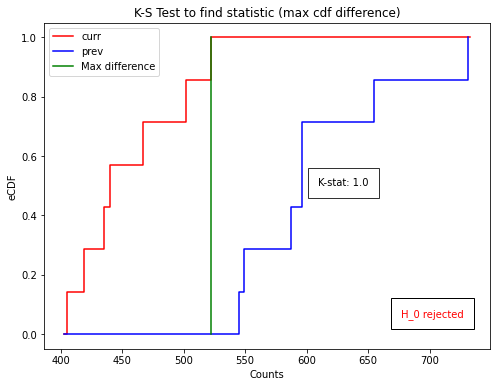

curr Table: 
   data  cdf_left  cdf_right  left_diff  right_diff
0   405  0.000000   0.142857   0.000000    0.142857
1   419  0.142857   0.285714   0.142857    0.285714
2   435  0.285714   0.428571   0.285714    0.428571
3   440  0.428571   0.571429   0.428571    0.571429
4   467  0.571429   0.714286   0.571429    0.714286
5   502  0.714286   0.857143   0.714286    0.857143
6   522  0.857143   1.000000   0.857143    1.000000


In [31]:
KS_test_2_pop(curr_wk_df.deaths.tolist(), prev_wk_df.deaths.tolist(), 'curr', 'prev', 0.05)


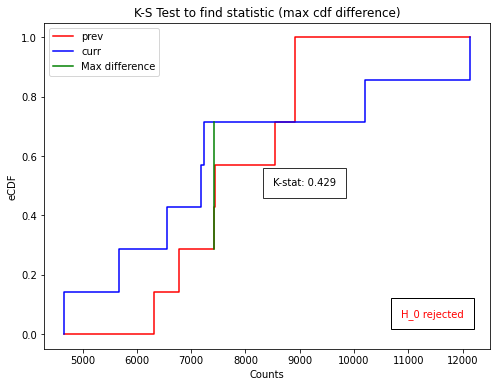

prev Table: 
   data  cdf_left  cdf_right  left_diff  right_diff
0  6313  0.000000   0.142857   0.285714    0.142857
1  6772  0.142857   0.285714   0.285714    0.142857
2  7430  0.285714   0.428571   0.428571    0.285714
3  7449  0.428571   0.571429   0.285714    0.142857
4  8542  0.571429   0.714286   0.142857    0.000000
5  8907  0.714286   0.857143   0.000000    0.142857
6  8909  0.857143   1.000000   0.142857    0.285714


In [32]:
KS_test_2_pop(curr_wk_df.cases.tolist(), prev_wk_df.cases.tolist(), 'curr', 'prev', 0.05)

The following are supporting functions for running 1 population K-S test.

In [0]:
def factorial(number):
    if number == 0: return 1
    retVal = 1
    while number!=1:
        retVal*=number
        number-=1
    return retVal

# returns cdf of a binomail distribution at a point
def bin_cdf(param):
    x = param['x']
    n = param['n']
    p = param['p']
    return binom.cdf(x, n, p)
#     n_fact = factorial(n)
#     curr_tot = 0
#     for i in range(0, x+1):
#         curr_tot += ((1/(factorial(i)*factorial(n-i))) * (p**i) * ((1-p)**(n-i)))
#     return curr_tot * n_fact

# finds parameters of a binomial distribution given a sample
def get_bin_parameters(X):
    X_np = np.array(X)
    mean = np.sum(X_np)/X_np.shape[0]
    variance = np.sum(np.square(X_np - mean))/X_np.shape[0]
    p_hat = 1-variance/mean
    n_hat = mean**2 /(mean - variance)
    return n_hat, p_hat

In [0]:
# finds parameters of a geometric distribution given a sample
def get_geo_parameters(X):
    X_np = np.array(X)
    p_hat = X_np.shape[0]/np.sum(X_np)
    return p_hat

# returns cdf of a geometric distribution at a point
def geo_cdf(param):
    x = param['x']
    p = param['p']
    return geom.cdf(x, p)
#     curr_sum = 0
#     for i in range(1, x+1):
#         curr_sum += (1-p)**(i-1)
#     return p*curr_sum

In [0]:
# finds parameters of a poisson distribution given a sample
def get_poisson_parameters(X):
    X_np = np.array(X)
    lambda_hat = np.sum(X_np)/X.shape[0]
    return lambda_hat

# returns cdf of a poisson distribution at a point
def poisson_cdf(param):
    x = param['x']
    lmbda = param['lmbda']
    return poisson.cdf(x, lmbda)
#     curr_sum = 0
#     for i in range(0, x+1):
#         curr_sum += ((lmbda**i/math.factorial(i))*math.exp(-lmbda))
#     return curr_sum

In [0]:
# K-S test for 1 population
def KS_test_1_pop(X, function, parameters, X_name, threshold):
    X_list = sorted(X)
    X_cdf_left = np.array([i for i in range(0, len(X_list))])/len(X_list)
    X_cdf_right = np.array([i for i in range(1, len(X_list)+1)])/len(X_list)
    
    X_table = pd.DataFrame(X_list, columns=['data'])
    X_table['cdf_left'] = X_cdf_left
    X_table['cdf_right'] = X_cdf_right    

    left_diff = []
    right_diff = []
    max_diff, x, y1, y2  = -math.inf, -1, -1, -1
    for i in range(X_table.shape[0]):
        parameters['x'] = X_table.data[i]
        left_diff.append(abs(X_table.cdf_left[i] - function(parameters)))
        right_diff.append(abs(X_table.cdf_right[i] - function(parameters)))
        if left_diff[-1]>max_diff:
            max_diff = left_diff[-1]
            x = X_table.data[i]
            y1 = X_table.cdf_left[i]
            y2 = function(parameters)
        if right_diff[-1]>max_diff:
            max_diff = right_diff[-1]
            x = X_table.data[i]
            y1 = X_table.cdf_right[i]
            y2 = function(parameters)
    X_table['left_diff'] = left_diff
    X_table['right_diff'] = right_diff
    
    if y1>y2: y1,y2 = y2,y1

    # calculations for drawing
    distribution_print = []
    for i in range(min(X_table.data)-30, max(X_table.data)+31):
        parameters['x'] = i
        distribution_print.append([i, function(parameters)])
    distribution_print = np.array(distribution_print).transpose()
    
    fig, ax = plt.subplots(figsize=(8,6))
    plt.step([(min(X_table.data)-30)] + X_table.data.tolist() + [(max(X_table.data)+30)], [0]+ X_table.cdf_right.tolist()+[1], where='post', color='red', label=X_name)
    plt.plot(distribution_print[0], distribution_print[1], color='blue', label='Distribution')
    plt.plot([x, x], [y1, y2], color='green', label='Max difference')
    ax.set_xlabel('Counts')
    ax.set_ylabel('eCDF/CDF')
    ax.set_title('K-S Test to find statistic (max cdf difference)')
#     ax.annotate(round(max_diff,3), xy=(x*1.005, min(y1,y2)+(y2-y1)/2))
    ax.text(x/(max(X_table.data)+30)-0.1, min(y1,y2)+(y2-y1)/2, "K-stat: " + str(round(max_diff,3)), bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10}, color='black', transform=ax.transAxes)
    ax.text(0.05, 0.75, 'H_0 rejected' if max_diff>threshold else 'H_1 accepted', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 10}, color='red', transform=ax.transAxes)
    plt.legend()
    plt.show()
    print(X_name + " Table: ")
    print(X_table)


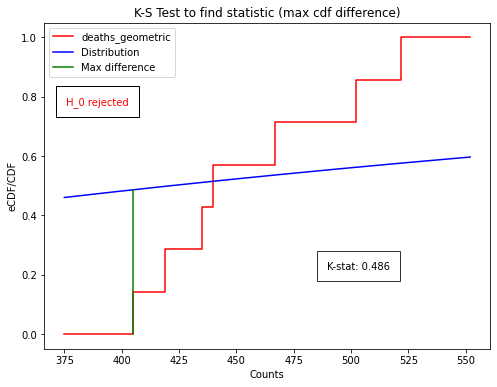

deaths_geometric Table: 
   data  cdf_left  cdf_right  left_diff  right_diff
0   405  0.000000   0.142857   0.486342    0.343484
1   419  0.142857   0.285714   0.355178    0.212321
2   435  0.285714   0.428571   0.225360    0.082503
3   440  0.428571   0.571429   0.086508    0.056350
4   467  0.571429   0.714286   0.035284    0.178141
5   502  0.714286   0.857143   0.152190    0.295047
6   522  0.857143   1.000000   0.280875    0.423732


In [0]:
param = {'p': get_geo_parameters(prev_wk_df.deaths)} 
KS_test_1_pop(curr_wk_df.deaths.tolist(), geo_cdf, param, 'deaths_geometric', 0.05)

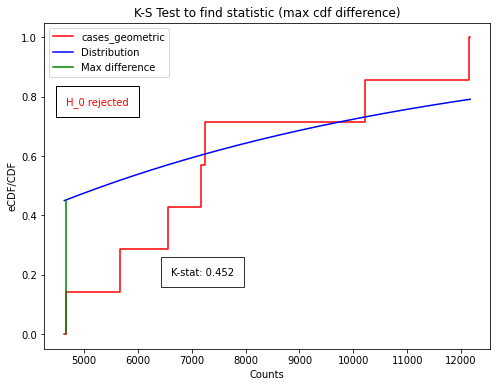

cases_geometric Table: 
    data  cdf_left  cdf_right  left_diff  right_diff
0   4667  0.000000   0.142857   0.451975    0.309118
1   5669  0.142857   0.285714   0.375504    0.232647
2   6563  0.285714   0.428571   0.285059    0.142202
3   7182  0.428571   0.571429   0.175112    0.032254
4   7238  0.571429   0.714286   0.035104    0.107753
5  10209  0.714286   0.857143   0.017409    0.125448
6  12139  0.857143   1.000000   0.066367    0.209225


In [0]:
param = {'p': get_geo_parameters(prev_wk_df.cases)} 
KS_test_1_pop(curr_wk_df.cases.tolist(), geo_cdf, param, 'cases_geometric', 0.05)

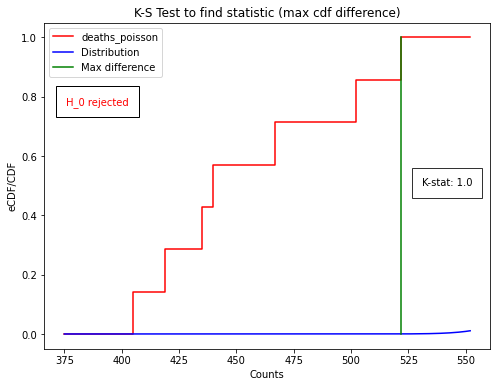

deaths_poisson Table: 
   data  cdf_left  cdf_right     left_diff  right_diff
0   405  0.000000   0.142857  1.015022e-18    0.142857
1   419  0.142857   0.285714  1.428571e-01    0.285714
2   435  0.285714   0.428571  2.857143e-01    0.428571
3   440  0.428571   0.571429  4.285714e-01    0.571429
4   467  0.571429   0.714286  5.714286e-01    0.714286
5   502  0.714286   0.857143  7.142808e-01    0.857138
6   522  0.857143   1.000000  8.569602e-01    0.999817


In [0]:
param = {'lmbda': get_poisson_parameters(prev_wk_df.deaths)}
KS_test_1_pop(curr_wk_df.deaths.tolist(), poisson_cdf, param, 'deaths_poisson', 0.05)

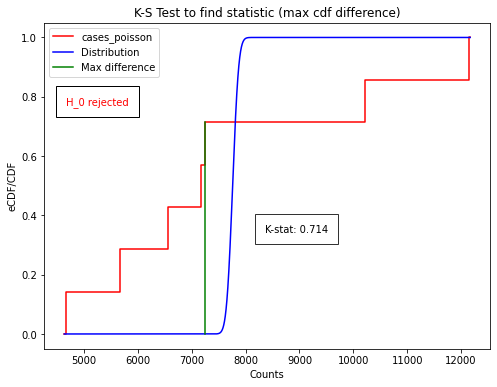

cases_poisson Table: 
    data  cdf_left  cdf_right  left_diff  right_diff
0   4667  0.000000   0.142857   0.000000    0.142857
1   5669  0.142857   0.285714   0.142857    0.285714
2   6563  0.285714   0.428571   0.285714    0.428571
3   7182  0.428571   0.571429   0.428571    0.571429
4   7238  0.571429   0.714286   0.571429    0.714286
5  10209  0.714286   0.857143   0.285714    0.142857
6  12139  0.857143   1.000000   0.142857    0.000000


In [0]:
param = {'lmbda': get_poisson_parameters(prev_wk_df.cases)}
KS_test_1_pop(curr_wk_df.cases.tolist(), poisson_cdf, param, 'cases_poisson', 0.05)

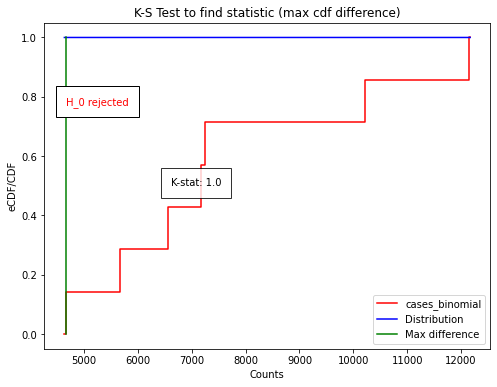

cases_binomial Table: 
    data  cdf_left  cdf_right  left_diff  right_diff
0   4667  0.000000   0.142857   1.000000    0.857143
1   5669  0.142857   0.285714   0.857143    0.714286
2   6563  0.285714   0.428571   0.714286    0.571429
3   7182  0.428571   0.571429   0.571429    0.428571
4   7238  0.571429   0.714286   0.428571    0.285714
5  10209  0.714286   0.857143   0.285714    0.142857
6  12139  0.857143   1.000000   0.142857    0.000000


In [0]:
n_hat, p_hat = get_bin_parameters(prev_wk_df.cases)
param = {'n': n_hat, 'p': p_hat}
KS_test_1_pop(curr_wk_df.cases.tolist(), bin_cdf, param, 'cases_binomial', 0.05)

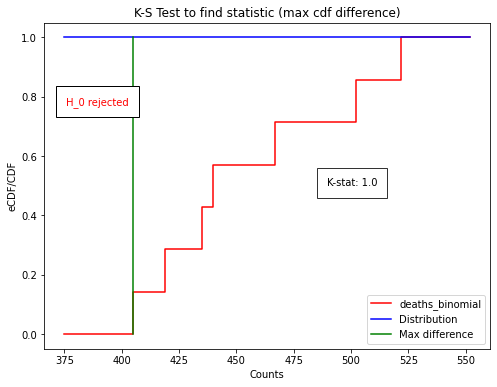

deaths_binomial Table: 
   data  cdf_left  cdf_right  left_diff  right_diff
0   405  0.000000   0.142857   1.000000    0.857143
1   419  0.142857   0.285714   0.857143    0.714286
2   435  0.285714   0.428571   0.714286    0.571429
3   440  0.428571   0.571429   0.571429    0.428571
4   467  0.571429   0.714286   0.428571    0.285714
5   502  0.714286   0.857143   0.285714    0.142857
6   522  0.857143   1.000000   0.142857    0.000000


In [0]:
n_hat, p_hat = get_bin_parameters(prev_wk_df.deaths)
param = {'n': n_hat, 'p': p_hat}
KS_test_1_pop(curr_wk_df.deaths.tolist(), bin_cdf, param, 'deaths_binomial', 0.05)

# Pearson Correlation - Required Inference 4

Here, we are going to observe the correlation of Closing price of IT Stocks with the #cases and #deaths of Covid Respectively.

In [59]:
import math  

correlation = []

Y_mean = df['Close'].mean()
Y_new_sum = ((df['Close'].apply(lambda x: x - Y_mean)).apply(lambda x: x*x)).sum()

X = ['cases', 'deaths']
for i in range(len(X)):
  X_mean = df[X[i]].mean()
  X_new_sum = ((df[X[i]].apply(lambda x: x - X_mean)).apply(lambda x: x*x)).sum()
  XY_sum = ((df[X[i]].apply(lambda x: x - X_mean)) * (df['Close'].apply(lambda x: x - Y_mean))).sum()

  correlation.append( XY_sum / (math.sqrt(Y_new_sum) * math.sqrt(X_new_sum)))
  
print (correlation)

[0.0357791145531692, 0.3340404048831093]


As we can observe from the result, both #cases and #deaths have correlation less than 0.5 with the closing price of stocks.
Thus, IT sector Stocks have little to NO correlation with the #cases and #deaths of Covid.

# BAYESIAN INFERENCE - Required inference 5

In [38]:
curr_filter = (current_df['date']>"2020-03-31") & (current_df['date']<"2020-05-01")
april_df = current_df.loc[curr_filter]

data = april_df.deaths

print(april_df.head())
print(data.head())

         date  cases  deaths
91 2020-04-01   9587     443
92 2020-04-02  10863     490
93 2020-04-03  12249     618
94 2020-04-04  13885     699
95 2020-04-05   9681     645
91    443
92    490
93    618
94    699
95    645
Name: deaths, dtype: int64


### Function to plot gamma distribution 

*   We observed that the posterior becomes a gamma distribution. (with parameters ( $(\sum X_i + 1$, $ n + \frac{1}{\bar{X}}$))

*   So we plotted the data with the number of new deaths, considering data of 7 days, 14 days, 21 days and 28 days.
*  Also, MAP for gamma$(\alpha, \beta)$ is $\frac{\alpha}{\beta}$

In [0]:
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt
def plot_gamma(a=1, b=1, label="0"):
  # fig, ax = plt.subplots(1, 1)
  x = np.linspace(gamma.ppf(0.01, a, scale=1/b),
                      gamma.ppf(0.99, a, scale=1/b), 1000)
  # ax.plot(x, gamma.pdf(x, a, scale=1/b), label=label)
  plt.plot(x, gamma.pdf(x, a, scale=1/b), label=label)
  plt.legend()

In [0]:
def plot_pdf(data):
  X = sum(data)
  l = len(data)
  alpha = X + 1
  x_hat_first_week = sum(data[:7])/7
  beta = (l + 1/x_hat_first_week)
  plot_gamma(alpha, beta, str(l) + " map: " + str(int(alpha/beta)) )

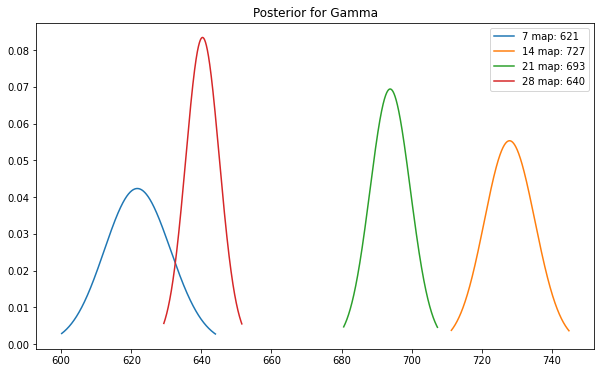

In [44]:
plt.figure(figsize=(10,6))
plot_pdf(data[:7])
plot_pdf(data[:14])
plot_pdf(data[:21])
plot_pdf(data[:28])
plt.title("Posterior for Gamma")
plt.show()

Results for Bayesian


*   We observe that the posterior follows a gamma distribution and as the data increases, it converges close to the mean.
*   The MAP value and the end of 4 weeks is 640.

# Chi Square Test - Sample Inference 1
We are testing whether Covid has contributed to an unseen volatility in the market

*   Hypothesis: COVID and market volatility are independent
*   We can use chisquare as it doesn't have assumptions
*   This hypothesis is particularly useful for long term investors as wrong entry and exit points in a volatile market can hinder profits and make us buy a stock for undesirable price
*   This is a significant analysis for intra day trading as a volatile market is the best market for them

For our analysis, a market is considered to be volatile if it's index changes more than 2% in a day.

In [0]:
stocks_df = all_stock_df.copy().rename(columns={'date':'Date Time'})

# Get the % change in the index for the day
stocks_df["Change_p"] = abs(round(all_stock_df['Change']/all_stock_df['Close'] * 100,2))
# stocks_df["Change_p"] = abs(round(data_stocks['Change'].diff() * 100,2))
# print(stocks_df.head())
stocks_df['Date Time'] = pd.to_datetime(stocks_df["Date Time"])

# stocks_filter = ((stocks_df['Date Time']>="2020-03-01") & (stocks_df['Date Time']<"2020-05-01")) or ((stocks_df['Date Time']>="2019-03-01") & (stocks_df['Date Time']<"2019-05-01"))
post_stocks_df = stocks_df[((stocks_df['Date Time']>="2020-03-01") & (stocks_df['Date Time']<"2020-05-01"))]
pre_stocks_df = stocks_df[((stocks_df['Date Time']>="2019-03-01") & (stocks_df['Date Time']<"2019-05-01"))]
stocks_df = stocks_df[((stocks_df['Date Time']>="2020-03-01") & (stocks_df['Date Time']<"2020-05-01")) | 
                      ((stocks_df['Date Time']>="2019-03-01") & (stocks_df['Date Time']<"2019-05-01"))]

def apply_map(x):
    if x>=pd.to_datetime("2020-03-01") and x<pd.to_datetime("2020-05-01"):
        return "post covid"
    else:
        return "pre covid"

def apply_map_volatility(x):
    if x>=2:
        return "volatile"
    else:
        return "not volatile"

stocks_df["Label"] = stocks_df["Date Time"].apply(apply_map)
stocks_df["Volatility"] = stocks_df["Change_p"].apply(apply_map_volatility)
stocks_df["Count"] = [1] * len(stocks_df["Change_p"])
# print(stocks_df.head())
stocks_df = stocks_df[["Label", "Volatility", "Count"]]

table = pd.pivot_table(stocks_df, values='Count', index=['Label'], columns=['Volatility'], aggfunc=np.count_nonzero)
print(table)
obs = [[table.loc["post covid", "not volatile"], table.loc["post covid", "volatile"]], 
     [table.loc["pre covid", "not volatile"], table.loc["pre covid", "volatile"]]]

g, p, dof, expctd = chi2_contingency(obs)
print("test statistic: ", g, "p value: ", p)
# df = stocks_df.set_index('Date Time').join(current_df.set_index('date'))
# print(df.head())

Volatility  not volatile  volatile
Label                             
post covid            15        28
pre covid             39         3
test statistic:  28.369103271188166 p value:  1.002526094596414e-07


Results for Sample Inference 1

As you can see above, the p value is 10^-7 which is quiet low even for a 99% confidence.

Hence we reject the hypothesis of Volatility and  covid being independent i.e, market volatility is highly dependent on covid 

# Sample Inference 2
As we see in below visualization that number of cases and deaths started increasing rapidly from March 1st 2020. Thus we wanted to analyze its impact on the stocks. <br>
For that, we have taken samples for 35 days before March 1st (Sample precovid) and 35 days post March 1st (Sample postcovid). We then run Paired ttest on these two data samples. <br>
We are running one-tailed test with null hypothesis as  mean of Sample precovid <= mean of sample postcovid. <br>

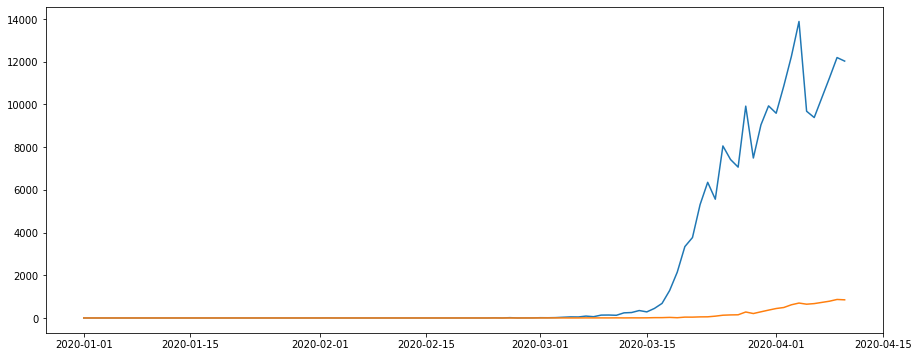

In [49]:
fig, ax = plt.subplots(figsize=(15,6))
n=100
plt.plot(current_df.date.tolist()[:n], current_df.cases.tolist()[:n])
plt.plot(current_df.date.tolist()[:n], current_df.deaths.tolist()[:n])

In [0]:
post_stocks_df = stock_df[stock_df['date']>="2020-03-01"]
pre_stocks_df = stock_df[stock_df['date']<"2020-03-01"]

In [0]:
def paired_ttest_one_tailed(pre_covid, post_covid):
    t_34_005 = 1.6909
    d_dist =  post_covid - pre_covid
    d_mean = np.sum(d_dist)/d_dist.shape[0]
    d_sd = (np.sum(np.square(d_dist - d_mean))/d_dist.shape[0])**0.5
    t_stat = d_mean/(d_sd/(d_dist.shape[0]**0.5))
    ret_str = "H_0 rejected" if t_stat < -t_34_005 else "Failed to reject H_0"
    return t_stat, ret_str


In [53]:
post_covid_stock_data = np.array(stock_df[stock_df['date']>="2020-03-01"].Close.tolist()[:35])
pre_covid_stock_data = np.array(stock_df[stock_df['date']<"2020-03-01"].Close.tolist()[-35:])

print("One tailed Paired T-statistic (mean of 35 days prior Covid and 35 days after Covid (03-01)): "+\
      str(paired_ttest_one_tailed(pre_covid_stock_data, post_covid_stock_data)))

One tailed Paired T-statistic (mean of 35 days prior Covid and 35 days after Covid (03-01)): (-10.5882212034989, 'H_0 rejected')


We see that null hypothesis is rejected. **This means the increase in count of covid cases/deaths has negatively impacted the stocks market.**

# Sample Inference 3 - Lockdown Impacts

**Multi Linear regression**

In [0]:
curr_filter = (covid_stock_df['date']>="2020-02-01") & (covid_stock_df['date']<"2020-03-20")
first_df = covid_stock_df.loc[curr_filter]
first_df
close_df=covid_stock_df.loc[curr_filter]

In [0]:
curr_filter1 = (covid_stock_df['date']>="2020-03-20") & (covid_stock_df['date']<="2020-04-30")
second_df = covid_stock_df.loc[curr_filter1]
close_second_df=covid_stock_df.loc[curr_filter1]

In [100]:
second_df['constant_value']=1 #Adding the constant  as 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [101]:
first_df['constant_value']=1 #Adding the constant  as 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
y = np.array(first_df['Close'])
y_second=np.array(second_df['Close'])
del first_df['date']
del first_df['Change']
del second_df['date']
del second_df['Change']
cols = first_df.columns.tolist()
cols_second=second_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
first_df=first_df[cols]
second_df=second_df[cols]
del first_df['Close']
cols = first_df.columns.tolist()
del second_df['Close']
cols = second_df.columns.tolist()
X=first_df.values
X_second=second_df.values
def fit(X,y):
  n = X.shape[0]
  P = X.shape[1] -1
  X_bar = np.mean(X,0)
  y_bar = np.mean(y)
  XX = X.T @ X
  beta = None
  y_hat= None
  SS_tot, SS_exp = None, None
  error = None
  beta = np.linalg.inv(XX) @ X.T @ y  #Calculating the coefficients
  y_hat = X @ beta #predicting the values
  prediction = y_hat
  residuals= y - y_hat # difference between predicted and actual values
  model=(X @ beta) + residuals # Multi Linear Regression model


  S = np.sum( (y - y_hat)**2 )
  SS_exp = np.sum( (y_hat - y_bar)**2 )
  SS_tot = np.sum( (y - y_bar)**2 )
  rsquarederror = SS_exp /SS_tot
  meansquareerror=S / (n - P -1)
  #S2_n_p_1 = S / (n - P -1)

  error=np.sqrt(meansquareerror)
  estimatesAndErrors=[]
  estimatesAndErrors.append(beta)
  estimatesAndErrors.append(prediction)
  estimatesAndErrors.append(residuals)
  output={'beta_values':beta,'predicted values':prediction,'residuals':residuals}
  print('-----ERROR-----------',error)
  return output
print("Linear regression for pre lock down scenario")
linearRegression=fit(X,y)
linearRegression

Linear regression for pre lock down scenario
-----ERROR----------- 108.3765567869489


{'beta_values': array([ 1.67673837e+03, -6.46590566e-02, -1.75889194e+01]),
 'predicted values': array([1676.73836887, 1676.73836887, 1676.73836887, 1676.73836887,
        1676.73836887, 1676.67370982, 1676.73836887, 1676.73836887,
        1676.73836887, 1676.73836887, 1676.73836887, 1676.73836887,
        1676.67370982, 1676.67370982, 1676.35041453, 1676.73836887,
        1675.76848302, 1676.73836887, 1676.5443917 , 1623.26036115,
        1605.28348744, 1639.36212221, 1673.44075699, 1656.11047385,
        1597.71837782, 1615.04866096, 1563.05781153, 1608.45343719,
        1554.71679323, 1384.00198006, 1351.21818239, 1118.62134011,
        1326.91300102]),
 'residuals': array([  19.25163113,   63.32163113,   73.81163113,   89.26163113,
          72.00163113,   95.68629018,   89.51163113,  108.27163113,
         102.94163113,  111.73163113,  105.49163113,  124.87163113,
         106.74629018,   66.60629018,   -6.03041453,  -59.55836887,
         -52.13848302, -139.61836887, -127.3043917

In [103]:
print("Linear regression for post lock down scenario")
linearRegrssion_second=fit(X_second,y_second) #applying linear regression for post lock down start data
linearRegrssion_second

Linear regression for post lock down scenario
-----ERROR----------- 73.63500491623421


{'beta_values': array([ 1.45509847e+03, -1.92779818e-02,  3.63199408e-01]),
 'predicted values': array([1405.19943496, 1352.23822335, 1378.74628865, 1346.64777591,
        1363.9740861 , 1373.03552207, 1385.7130352 , 1397.2869406 ,
        1431.17779997, 1423.64946733, 1443.41970878, 1518.58853826,
        1523.56404964, 1534.89737251, 1577.58392548, 1597.90627941,
        1523.56348819, 1521.21813306, 1548.88825726, 1511.2595441 ,
        1549.86342201, 1527.96363464, 1503.62400581, 1440.61566036,
        1503.80333756, 1524.93587241, 1485.17856512, 1480.75763126]),
 'residuals': array([-153.53943496, -112.84822335,  -11.64628865,   16.61222409,
          85.8459139 ,   10.00447793,   55.8869648 ,   17.0730594 ,
         -83.49779997,  -45.28946733,  -87.81970878,  -43.99853826,
         -24.60404964,  -35.69737251,  -75.34392548,  -33.04627941,
           7.08651181,   28.45186694,   22.11174274,   31.7004559 ,
         -70.18342201,    8.96636536,   22.71599419,  117.88433964,
     

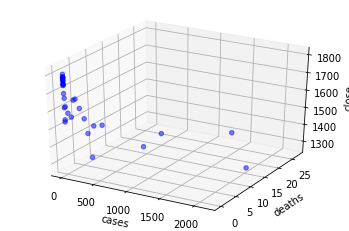

In [104]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(first_df['cases'],first_df['deaths'],close_df['Close'],c='blue', marker='o', alpha=0.5)
ax.set_xlabel('cases')
ax.set_ylabel('deaths')
ax.set_zlabel('close')
plt.show()

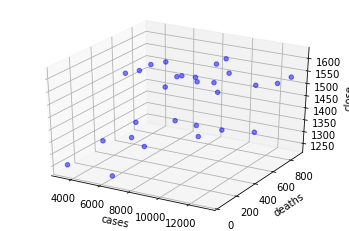

In [105]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(second_df['cases'],second_df['deaths'],close_second_df['Close'],c='blue', marker='o', alpha=0.5)
ax.set_xlabel('cases')
ax.set_ylabel('deaths')
ax.set_zlabel('close')
plt.show()

On assumption that the relation between stock prices, number of deaths, number of cases is linear,we tried to estimate the coefficients of Multi Linear Regression model and predicted the stock prices pre lock down , post lock down. The data is divided in to two parts, one is from Feb 1 to March 19 and the other is  from March 20 to April 30. The lockdown in California started on March 20, Hence the division in the data to see the impact on Tech stocks. We calculated the error values and found that the RMSE is around 108 and 73. But from the 3D scatter plots between stocks,deaths,cases we can notice that relation is not linear which explains the reason for  high RMSE.Both during the pre-lock down and post lock down,Although there is some dependency, the stock prices aren't linearly dependent on no.of deaths and no.active cases based on 2 months data we analyzed. 

In [106]:
print('Parameter Estimates for data pre lock down')
    
df3 = pd.DataFrame(data = {'Parameter Estimate':linearRegression['beta_values']}, index = ['intercept', 'cases', 'deaths'])
        
display(df3.round(3))

Parameter Estimates for data pre lock down


,Parameter Estimate
intercept,1676.738
cases,-0.065
deaths,-17.589


In [107]:
print('Parameter Estimates for data post lock down')
    
df3 = pd.DataFrame(data = {'Parameter Estimate':linearRegrssion_second['beta_values']}, index = ['intercept', 'cases', 'deaths'])
        
display(df3.round(3))

Parameter Estimates for data post lock down


,Parameter Estimate
intercept,1455.098
cases,-0.019
deaths,0.363


**Pearson Correlation between pre-covid and post-covid stocks data**
<br>


In [60]:
precovid = (all_stock_df['date']>="2019-02-01") & (all_stock_df['date']<="2019-05-01")
postcovid = (all_stock_df['date']>="2020-02-01") & (all_stock_df['date']<"2020-05-01")
stocks_precovid = all_stock_df.loc[precovid]
stocks_postcovid = all_stock_df.loc[postcovid]
# stocks_df = pd.concat([stocks_precovid, stocks_postcovid], axis=1, sort=False)
print (stocks_precovid.shape, stocks_postcovid.shape)

(62, 3) (62, 3)


This compares the correlation between stocks for the months of february-april for 2019 vs 2020 i.e. pre-covid Stocks' Closing Price vs Post-covid Stocks' Closing Price.

In [61]:
import math  
import statistics 
X = stocks_precovid['Close'].values.tolist()
Y = stocks_postcovid['Close'].values.tolist()

Y_mean = statistics.mean(Y) 
Y_new = [number - Y_mean for number in Y]
Y_new_2 = [number*number for number in Y_new]
Y_new_sum = sum(Y_new_2)

X_mean = statistics.mean(X) 
X_new = [number - X_mean for number in X]
X_new_2 = [number*number for number in X_new]
X_new_sum = sum(X_new_2)

X_new_Y_new = [a*b for a, b in zip(X_new, Y_new)]
XY_sum = sum(X_new_Y_new)

correlation = XY_sum / (math.sqrt(Y_new_sum) * math.sqrt(X_new_sum))
  
print(correlation)

-0.5017291619499947


From the above value, we know that the pre-covid and post-covid Stocks' Closing Price is negatively correlated as expected.

**Pearson Correlation between two date ranges of Covid**<br>


1.   Here, we have taken the first range from february 2020 to March 19, 2020. This signifies the period when Covid began but Lockdown had NOT been enforced in the any of the 3 states.
2.   The second range is from March 20, 2020 till April 30, 2020. Lockdown in California began on March 20, in New York shortly after that and in Washington just a few days before that.



In [0]:
curr_filter = (covid_stock_df['date']>="2020-02-01") & (covid_stock_df['date']<"2020-03-20")
covid_start = covid_stock_df.loc[curr_filter]
curr_filter = (covid_stock_df['date']>="2020-03-20") & (covid_stock_df['date']<"2020-05-01")
covid_end = covid_stock_df.loc[curr_filter]



1.   From the first correlation between #cases and IT Stocks Closing Price we discover a very high negative correlation. This means as #cases increased, the closing price went down.
2.   The same is observed for correlation between #deaths and IT Stocks Closing Price. 
3.   This is the period when Lockdown had not been enforced.





In [63]:
import math  

correlation = []

Y_mean = covid_start['Close'].mean()
Y_new_sum = ((covid_start['Close'].apply(lambda x: x - Y_mean)).apply(lambda x: x*x)).sum()

X = ['cases', 'deaths']
for i in range(len(X)):
  X_mean = covid_start[X[i]].mean()
  X_new_sum = ((covid_start[X[i]].apply(lambda x: x - X_mean)).apply(lambda x: x*x)).sum()
  XY_sum = ((covid_start[X[i]].apply(lambda x: x - X_mean)) * (covid_start['Close'].apply(lambda x: x - Y_mean))).sum()

  correlation.append( XY_sum / (math.sqrt(Y_new_sum) * math.sqrt(X_new_sum)))
  
print (correlation)

[-0.6580513902738824, -0.7691389734979914]


1.   From the first correlation between #cases and IT Stocks Closing Price we discover almost no correlation. This means the #cases had no effect on the closing price.
2.  For correlation between #deaths and IT Stocks Closing Price, we see a positive correlation. 
3.   This is the period when Lockdown had been enforced.


In [64]:
import math  

correlation = []

Y_mean = covid_end['Close'].mean()
Y_new_sum = ((covid_end['Close'].apply(lambda x: x - Y_mean)).apply(lambda x: x*x)).sum()

X = ['cases', 'deaths']
for i in range(len(X)):
  X_mean = covid_end[X[i]].mean()
  X_new_sum = ((covid_end[X[i]].apply(lambda x: x - X_mean)).apply(lambda x: x*x)).sum()
  XY_sum = ((covid_end[X[i]].apply(lambda x: x - X_mean)) * (covid_end['Close'].apply(lambda x: x - Y_mean))).sum()

  correlation.append( XY_sum / (math.sqrt(Y_new_sum) * math.sqrt(X_new_sum)))
  
print (correlation)

[0.12133311653208884, 0.6307880517207141]


1. From the inferences observed above, we see that Lockdown, especially in California- the IT hub, had a great impact on the IT market. 
2. The pearson correlation in the required inferences also makes sense now, that for the overall period, there is no correlation.
3. This may be due to the sharp increase in negative correlation in the first half (before Lockdown) followed by increase in positive correlation in the second half (After lockdown) which balances out the overall effect to be no correlation.